# Multi-armed bandits


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [13]:
class Bandit(object):
    def __init__(self, runs, arms, n_pulls, epsilon, estimates, ucb_val=2, sample_average=True, update_rule=False, confidence_interval= False, gradient=False):
        ############### Initial parameters
        self.runs = runs
        self.arms = arms
        self.n_pulls = n_pulls 
        self.epsilon = epsilon
        self.ucb_val = ucb_val
        ################ True values
        self.q_a = np.random.normal(0,1,(runs,arms)) 
        self.optimal_arm = np.argmax(self.q_a,1) 
        ############### Matrices to store runs
        #matrix to store estimated rewards
        self.estimates = estimates
        ############### variables to store count of choices
        self.action_counts = np.ones(( runs, arms))
        self.reward_array = []
        self.optimal_pull_array = []
        ############## Types of algorithm: boolean
        self.sample_average = sample_average
        self.update_rule = update_rule
        self.confidence_interval = confidence_interval
        self.gradient = gradient
        
    def choose_machine(self, sample, run ):
        # select the machine according to the method specified
        random_probability = random.random() # select probability for greedy search 
        
        if self.confidence_interval: # UCB machine selection
            CI = self.estimates[run] + self.ucb_val * np.sqrt(np.log(run)/self.action_counts[run])
            machine = np.argmax(CI)
            return machine
        
        if self.gradient: # Gradient machine selection
            e_ht = np.exp(self.estimates[run])
            self.pi_t = e_ht / np.sum(e_ht)
            machine = np.random.choice(np.arange(10), p=self.pi_t)
            return machine
        
        # greedy machine selection
       
        elif random_probability < self.epsilon: 
            machine = random.randrange(10) # random number between 0 and 9
            return machine
        machine = np.argmax(sample) # choose the best machine
        
        return machine
    
    def pay_player(self, run, machine, average_reward):
        # pull the lever of the machine
        
        pull_reward = np.random.normal(self.q_a[run][machine], 1) # sample using the mean from true values
        self.action_counts[run][machine] += 1
        
        # update estimates according to the selected method
        if self.sample_average: 
            self.estimates[run][machine] += (pull_reward - self.estimates[run][machine])/self.action_counts[run][machine]
        if self.update_rule:
            self.estimates[run][machine] += (pull_reward - self.estimates[run][machine])*0.1
        if self.gradient: # 
            for each_machine in range(10):
                if each_machine == machine:
                    self.estimates[run][each_machine] += 0.1 * (pull_reward- (np.sum(average_reward)/(run+1)) )*(1-self.pi_t[each_machine])
                else:
                    self.estimates[run][each_machine] -= 0.1 * (pull_reward- (np.sum(average_reward)/(run+1)) )*(self.pi_t[each_machine])
                
            
        return pull_reward
    
    def play(self):
        
        for pull in range(1, self.n_pulls+1):

            pulls = []
            count_opt_pulls = 0
            average_reward = []
            for run in range(self.runs):
                
                machine = self.choose_machine(self.estimates[run], run)
                    
                if machine == self.optimal_arm[run]:
                    count_opt_pulls+=1
                
                pull_reward = self.pay_player(run, machine, average_reward)
                average_reward.append(pull_reward)
                pulls.append(pull_reward)
                
            self.optimal_pull_array.append(count_opt_pulls/self.runs)   
            self.reward_array.append(np.mean(pulls))
    
        return self.reward_array , self.optimal_pull_array
    
    

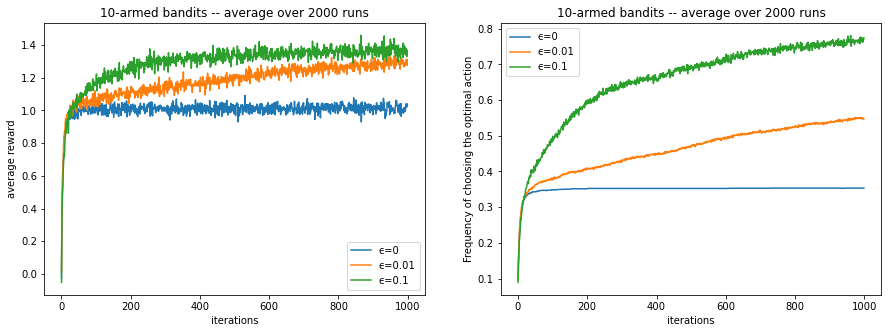

In [11]:
# Greedy, epsilon-greedy
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 5))
for epsilon in [0,0.01,0.1]:
    
    rewards, optimal_pulls = Bandit(
        runs=2000, 
        arms=10, 
        n_pulls=1000, 
        epsilon=epsilon, 
        estimates= np.zeros(( 2000, 10 ))
    ).play()
    
    ax1.plot(range(1000),rewards , label=f"ϵ={epsilon}")
    ax2.plot(range(1000) , optimal_pulls, label=f"ϵ={epsilon}")
ax1.set_title('10-armed bandits -- average over 2000 runs')
ax1.set_ylabel('average reward')
ax1.set_xlabel('iterations')
ax1.legend()

ax2.set_title('10-armed bandits -- average over 2000 runs')
ax2.set_ylabel("Frequency of choosing the optimal action")
ax2.set_xlabel("iterations")
ax2.legend()
plt.show()

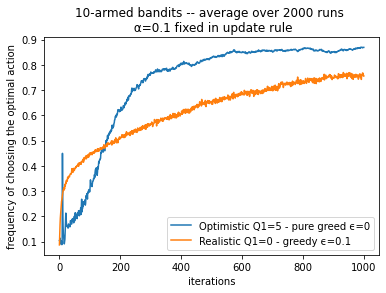

In [7]:
# using optimistic starting points
optimistic_estimates = 5*np.ones((2000,10))

rewards_optimistic, optimal_pulls_optimistic = Bandit(
    runs=2000, 
    arms=10, 
    n_pulls=1000, 
    epsilon=0, 
    estimates = optimistic_estimates , 
    sample_average=False, 
    update_rule=True ).play()

plt.plot(range(1000) , optimal_pulls_optimistic, label=f"Optimistic Q1=5 - pure greed ϵ=0" )

rewards_realistic, optimal_pulls_realistic = Bandit(
    runs=2000, 
    arms=10, 
    n_pulls=1000, 
    epsilon=0.1, 
    estimates = np.zeros((2000,10)) , 
    sample_average=False, 
    update_rule=True ).play()

plt.plot(range(1000) , optimal_pulls_realistic, label=f"Realistic Q1=0 - greedy ϵ=0.1" )
plt.title('10-armed bandits -- average over 2000 runs \n α=0.1 fixed in update rule')
plt.xlabel('iterations')
plt.ylabel('frequency of choosing the optimal action')
plt.legend()
plt.show()


/var/folders/n_/lmz09xv942jc4f7l1r3x_j140000gn/T/ipykernel_33909/568143388.py:30: RuntimeWarning: divide by zero encountered in log
  CI = self.estimates[run] + self.ucb_val * np.sqrt(np.log(run)/self.action_counts[run])
/var/folders/n_/lmz09xv942jc4f7l1r3x_j140000gn/T/ipykernel_33909/568143388.py:30: RuntimeWarning: invalid value encountered in sqrt
  CI = self.estimates[run] + self.ucb_val * np.sqrt(np.log(run)/self.action_counts[run])


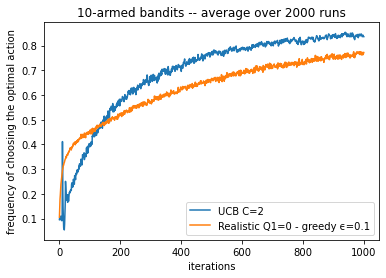

In [14]:
# UCB, using a confidence interval

rewards_ucb, optimal_pulls_ucb = Bandit(
    runs=2000, 
    arms=10, 
    n_pulls=1000, 
    epsilon=0, 
    estimates = 9*np.ones((2000,10)) , #initialized optimistically Q=9 
    sample_average=True, 
    update_rule=False, 
    confidence_interval=True ).play()

plt.plot(range(1000) , optimal_pulls_ucb, label=f"UCB C=2" )

rewards_01, optimal_pulls_01 = Bandit(
    runs=2000, 
    arms=10, 
    n_pulls=1000, 
    epsilon=0.1, 
    estimates = np.zeros((2000,10)) , 
    sample_average=False, 
    update_rule=True ).play()

plt.plot(range(1000) , optimal_pulls_01, label=f"Realistic Q1=0 - greedy ϵ=0.1" )
plt.title('10-armed bandits -- average over 2000 runs')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('frequency of choosing the optimal action')
plt.show()

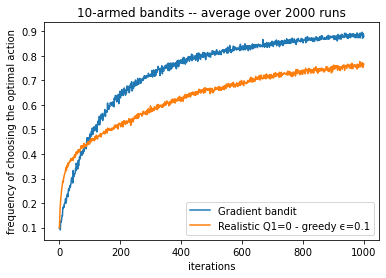

In [9]:
# stochastic gradient

rewards_gradient, optimal_pulls_gradient = Bandit(
    runs=2000, 
    arms=10, 
    n_pulls=1000, 
    epsilon=0, 
    estimates =5* np.ones((2000,10)) , 
    gradient=True ).play()

plt.plot(range(1000) , optimal_pulls_gradient, label=f"Gradient bandit" )
plt.plot(range(1000) , optimal_pulls_01, label=f"Realistic Q1=0 - greedy ϵ=0.1" )
plt.title('10-armed bandits -- average over 2000 runs')
plt.xlabel('iterations')
plt.ylabel('frequency of choosing the optimal action')
plt.legend()
plt.show()

Code Bonus: Vous pouvez maintenant tester quelques cas supplémentaires

Peut-on choisir un meilleur ε que 0.1 pour ε-greedy?

Que se passe-t-il si l'initialisation n'est pas assez optimiste ou trop optimiste?

Comment varie la courbe de performance selon la valeur du paramètre c de UCB?

α pour la montée de gradient.

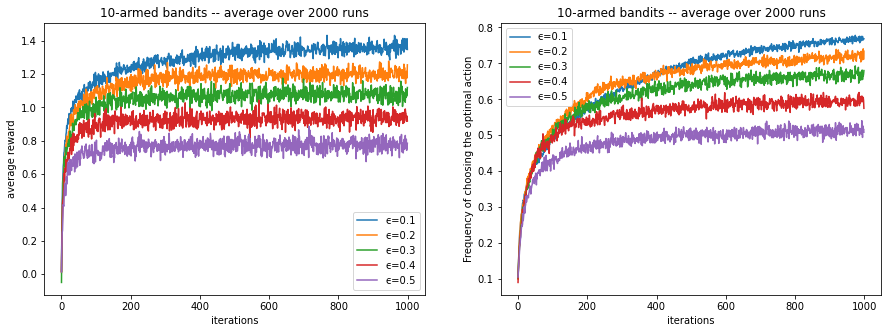

In [24]:
# Choosing an optimal epsilon
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 5))
for epsilon in [0.1,0.2,0.3,0.4,0.5]:    
    rewards, optimal_pulls = Bandit(
        runs=2000, 
        arms=10, 
        n_pulls=1000, 
        epsilon=epsilon, 
        estimates= np.zeros(( 2000, 10 ))
    ).play()
    
    ax1.plot(range(1000),rewards , label=f"ϵ={epsilon}")
    ax2.plot(range(1000) , optimal_pulls, label=f"ϵ={epsilon}")
ax1.set_title('10-armed bandits -- average over 2000 runs')
ax1.set_ylabel('average reward')
ax1.set_xlabel('iterations')
ax1.legend()

ax2.set_title('10-armed bandits -- average over 2000 runs')
ax2.set_ylabel("Frequency of choosing the optimal action")
ax2.set_xlabel("iterations")
ax2.legend()
plt.show()

# we can see that epsilon = 0.1 is the best value as over 1000 iterations,
# as it has the highest frequency of choosing the 
# optimal value along with the highest average reward. 
# We can see that as epsilon increases the value at convergence decreases.

[]

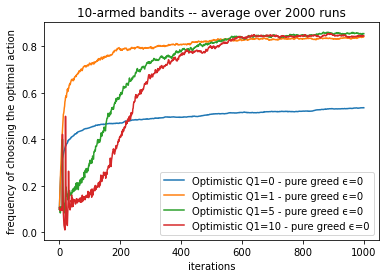

In [23]:
# Comparing optimistic starting values 
for optimistic_value in [0,1,5,10]:
    optimistic_estimates = optimistic_value*np.ones((2000,10))
    rewards_optimistic, optimal_pulls_optimistic = Bandit(
        runs=2000, 
        arms=10, 
        n_pulls=1000, 
        epsilon=0, 
        estimates = optimistic_estimates , 
        sample_average=False, 
        update_rule=True ).play()

    plt.plot(range(1000) , optimal_pulls_optimistic, label=f"Optimistic Q1={optimistic_value} - pure greed ϵ=0" )
plt.title('10-armed bandits -- average over 2000 runs')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('frequency of choosing the optimal action')
plt.plot()

# Starting with optimistic values converges to the same frequency of choosing the optimal actions over 1000 iterations
# regardless of the value chosen,
# as opposed to starting with zero which converges to a lower frequency. 
# However, as the optimal value increases the speed of convergence decreases

/var/folders/n_/lmz09xv942jc4f7l1r3x_j140000gn/T/ipykernel_33909/568143388.py:30: RuntimeWarning: divide by zero encountered in log
  CI = self.estimates[run] + self.ucb_val * np.sqrt(np.log(run)/self.action_counts[run])
/var/folders/n_/lmz09xv942jc4f7l1r3x_j140000gn/T/ipykernel_33909/568143388.py:30: RuntimeWarning: invalid value encountered in sqrt
  CI = self.estimates[run] + self.ucb_val * np.sqrt(np.log(run)/self.action_counts[run])


[]

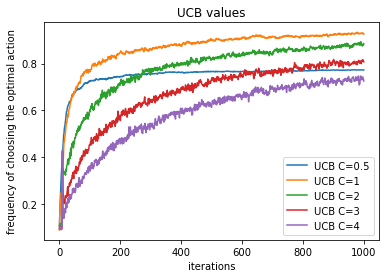

In [26]:
# comparing ucb parameters
for ucb_value in [0.5,1,2,3,4]:
    rewards_ucb, optimal_pulls_ucb = Bandit(
        runs=2000, 
        arms=10, 
        n_pulls=1000, 
        epsilon=0, 
        ucb_val = ucb_value,
        estimates = np.zeros((2000,10)) ,  
        sample_average=True, 
        update_rule=False, 
        confidence_interval=True ).play()

    plt.plot(range(1000) , optimal_pulls_ucb, label=f"UCB C={ucb_value}")
    
plt.legend()
plt.title('UCB values')
plt.xlabel('iterations')
plt.ylabel('frequency of choosing the optimal action')
plt.plot()

# the frequency of choosing the optimal action decreases as C increases past 1.